In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

from tqdm import tqdm

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_cuda_device_or_cpu():
  if torch.cuda.is_available():
    cuda_count = torch.cuda.device_count()
    
    no = 0
    mem_available = 0

    for i in range(cuda_count):
      tmp_available = torch.cuda.mem_get_info(i)[0]
      if mem_available < tmp_available:
        no = i
        mem_available = tmp_available
    return f'cuda:{no}'
  return 'cpu'

device = get_cuda_device_or_cpu()
device

'cuda:1'

In [3]:
def get_model(dim_z: int, batch_size=128, less_than=10):

  # Download training data from open datasets.
  training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
  )

  training_data.data = training_data.data[training_data.targets < less_than]
  training_data.targets = training_data.targets[training_data.targets < less_than]

  # Create data loaders.
  dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

  encoder = nn.Sequential(
    nn.Linear(784, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, dim_z),
  )

  decoder = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 128),
    nn.Tanh(),
    nn.Linear(128, 512),
    nn.Tanh(),
    nn.Linear(512, 784),
    nn.Sigmoid(),
  )

  model = nn.Sequential(OrderedDict([
            ('encoder', encoder),
            ('decoder', decoder),
          ]))

  optimizer = torch.optim.Adam(model.parameters())

  return model, dataloader, optimizer

In [4]:
def train(model, dataloader, optimizer, run, epochs=5):
  
  model.to(device)
  model.train()

  hist = torch.zeros(0)

  for _ in tqdm(range(epochs)):
    tmp = run(model, dataloader, optimizer)
    hist = torch.cat([hist, tmp])
  
  return hist

In [59]:
def run_un(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  # ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]]).to(device)
  ps = torch.tensor([[-1, 0], [0, 0], [1, 0]]).to(device)

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)
    # x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    pred_labels = h[:, 2:]
    labels = pred_labels.argmax(dim=1)
    idx = F.one_hot(labels, num_classes=3)
    
    dist = (((torch.stack([z]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


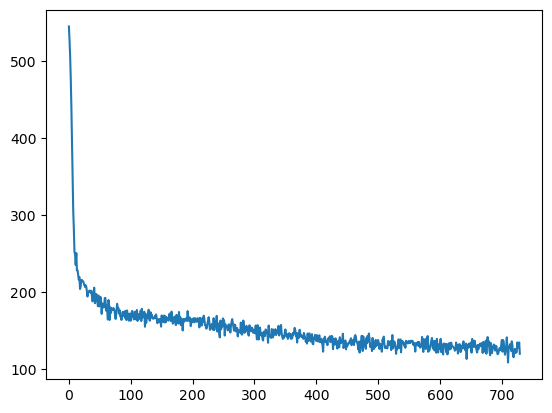

In [60]:
model, dataloader, optimizer = get_model(dim_z=5, batch_size=128, less_than=3)
hist = train(model, dataloader, optimizer, run_un, 5)
plt.plot(hist)
plt.show()

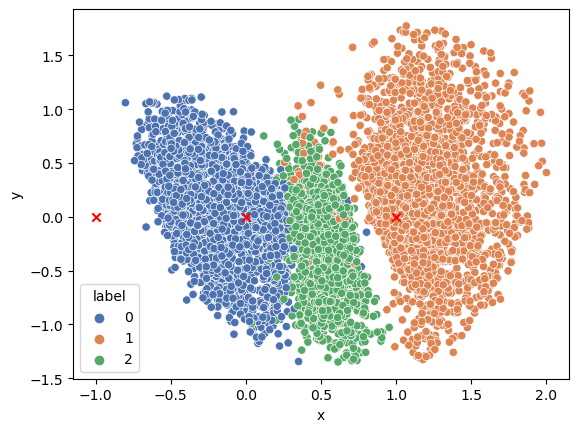

In [62]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in dataloader:
    x = x.reshape([-1, 28*28])
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([-1, 0, 1], [0, 0, 0], marker='x', color='red')

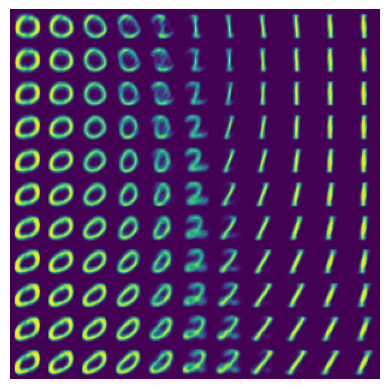

In [63]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1, 2, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


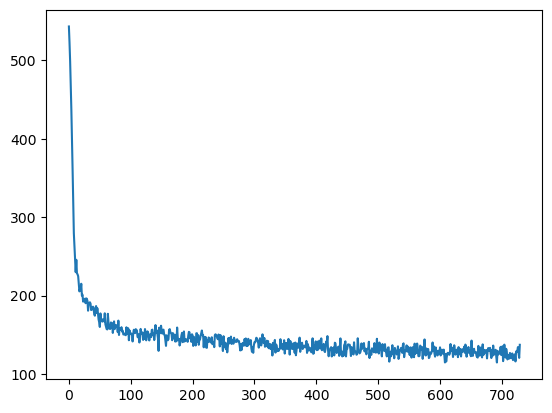

In [64]:
model, dataloader, optimizer = get_model(dim_z=5, batch_size=128, less_than=3)
hist = train(model, dataloader, optimizer, run_un, 5)
plt.plot(hist)
plt.show()

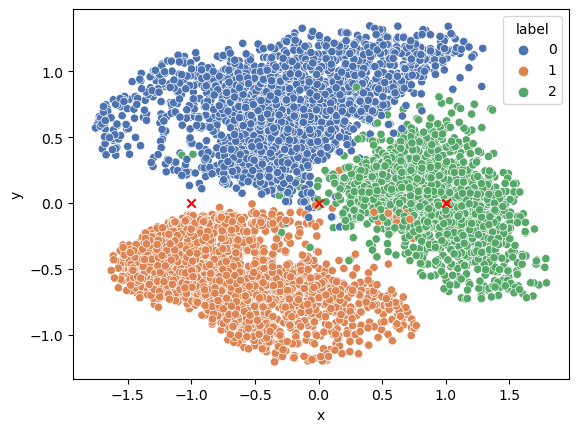

In [65]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in dataloader:
    x = x.reshape([-1, 28*28])
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([-1, 0, 1], [0, 0, 0], marker='x', color='red')

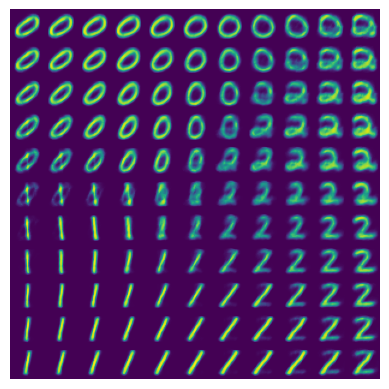

In [66]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1.5, 1.5, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

In [12]:
def run_all_two(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  # ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]]).to(device)
  ps = torch.tensor([[-1, 0], [1, 0]]).to(device)

  num_classes = len(ps)

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    pred_labels = h[:, 2:]
    labels = pred_labels.argmax(dim=1)
    idx = F.one_hot(labels, num_classes=num_classes)
    
    dist = (((torch.stack([z]*num_classes, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


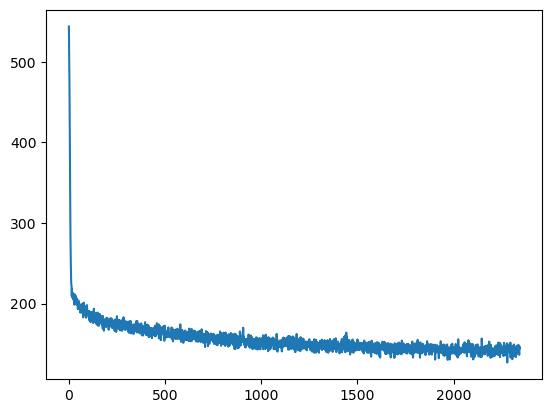

In [13]:
model, dataloader, optimizer = get_model(dim_z=4)
hist = train(model, dataloader, optimizer, run_all_two, 5)
plt.plot(hist)
plt.show()

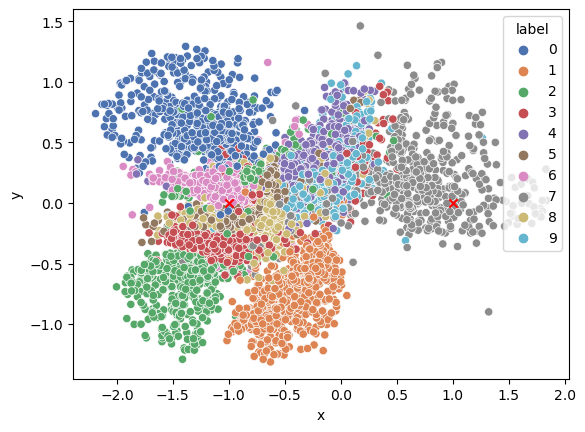

In [14]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

with torch.no_grad():
  idx = 0
  for x, y in dataloader:
    x = x.reshape([-1, 28*28])
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    
    tmp = pd.DataFrame(
      {
        'x': z[:, 0],
        'y': z[:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([-1, 1], [0, 0], marker='x', color='red')

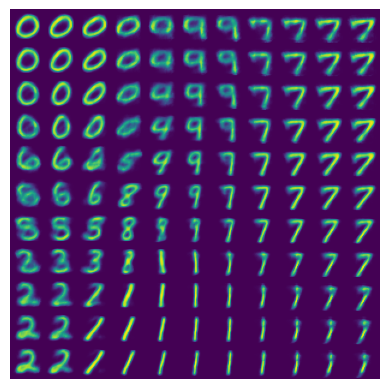

In [15]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1.5, 1.5, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  